<a href="https://colab.research.google.com/github/XenoicZ/EPE/blob/main/GNN_MDN_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/atlas-calo-ml/gn4pions_eastbay.git

Cloning into 'gn4pions_eastbay'...
remote: Enumerating objects: 1141, done.
remote: Counting objects: 100% (1141/1141), done.
remote: Compressing objects: 100% (446/446), done.
remote: Total 1141 (delta 691), reused 1131 (delta 681), pack-reused 0
Receiving objects: 100% (1141/1141), 213.90 MiB | 30.87 MiB/s, done.
Resolving deltas: 100% (691/691), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!pip install atlas_mpl_style
%cd gn4pions_eastbay
import atlas_mpl_style
import gn4pions.modules.resolution_util as ru
import gn4pions.modules.plot_util as pu
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
%cd /content/drive/MyDrive/ml4pion
import util.resolution_util_modified as rum
import tensorflow_probability as tfp

truth_part_e_mean = 1.92469358
truth_part_e_std = 0.8289864

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/gn4pions_eastbay
/content/drive/MyDrive/ml4pion


#Loss Info#

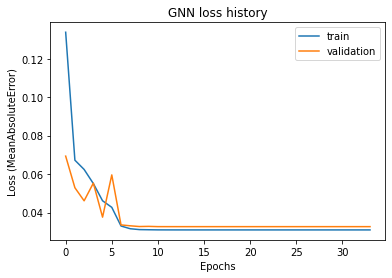

In [ ]:
with np.load('/content/drive/MyDrive/ml4pion/model/GNN/losses.npz') as data:
    train_loss = data['training']
    val_loss = data['validation']
plt.title('GNN loss history')
plt.plot(np.mean(train_loss,axis=1), label='train')
plt.plot(np.mean(val_loss,axis=1), label='validation')
plt.ylabel('Loss (MeanAbsoluteError)')
plt.xlabel('Epochs')
plt.legend()

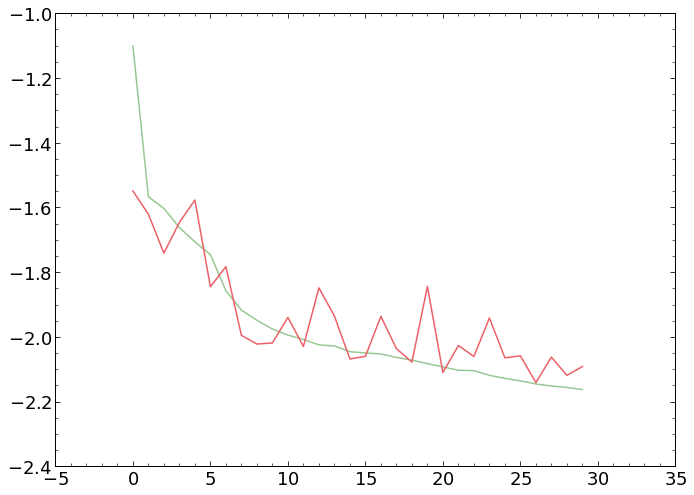

In [107]:
plt.plot(np.load('/content/drive/MyDrive/ml4pion/model/loss_GNN_MDN_samp2.npy')[0])
plt.plot(np.load('/content/drive/MyDrive/ml4pion/model/loss_GNN_MDN_samp2.npy')[1])

In [105]:
with np.load('/content/drive/MyDrive/ml4pion/MDN/losses.npz') as data:
    train_loss = data['training']
    val_loss = data['validation']
plt.title('GNN+MDN loss history')
plt.plot(np.mean(train_loss,axis=1), label='train')
plt.plot(np.mean(val_loss,axis=1), label='validation')
plt.ylabel('Loss -log.probability')
plt.xlabel('Epochs')
plt.legend()

AttributeError: ignored

#Response Eval#

In [51]:
def make_response_plot(y_true, y_pred, pion_label, f_name=''):
    y_ratio = y_pred/y_true

    p_r = pearsonr(y_true,y_pred)[0]
    s_r = spearmanr(y_true,y_pred)[0]
    mse = mean_squared_error(y_true,y_pred)
    mae = mean_absolute_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    print("r2:{:.3f}".format(r2))
    print("PearsonR:{:.3f}, SpearmanR:{:.3f}, MSE:{:.3f}, MAE:{:.3f}".
          format(p_r, s_r, mse, mae))
    xcenter, medRegCNN = ru.responsePlot(y_true, y_ratio,
                                         figfile = f_name,
                                         statistic = 'median',
                                         atlas_x = 0.55, atlas_y = 0.95, simulation = True,

                                         textlist = [{'x': 0.55, 'y': 0.85, 'text': pion_label}])
    return xcenter, medRegCNN

def tol_mean(weight, mu):
  # total mean of 3 Gaussian mixtures
  sum = weight * mu
  return np.sum(sum, axis=1)

def tol_std(weight, mu, sigma):
  sum_1 = np.sum(weight * sigma**2, axis=1)
  sum_2 = np.sum(weight * mu**2, axis=1)
  sum_3 = np.sum(weight * mu, axis=1)**2
  return np.sqrt(sum_1 + sum_2 - sum_3)

def eval_cal(weight, mean, std, mode):
  # Return predicted value and unertainty using different technique (mode)
  # 'max': mean and std of the mode with largest weight
  # 'mixture': overall mean and std the mixture distribution
  # integer : mean and std of n-th largest distribution 
  if mode == 'max':
    weight_mask = weight.max(axis=1, keepdims=True) ==  weight
    pred_mean = mean[weight_mask].flatten()
    pred_std = std[weight_mask].flatten()
  elif mode == 'mixture':
    pred_mean = tol_mean(weight, mean).flatten()
    pred_std = tol_std(weight, mean, std).flatten()
  elif isinstance(mode, int) and mode <= weight.shape[1]:
    weight_index = np.argsort(weight)[:,-mode]
    pred_mean = np.take_along_axis(mean, weight_index[:,None], axis=1).flatten()
    pred_std = np.take_along_axis(std, weight_index[:,None], axis=1).flatten()
  else:
    print('unknown mode name')
  return pred_mean, pred_std

def inv_normalize(data):
  return data * truth_part_e_std + truth_part_e_mean

def mean_exp(mean, std):
  return 10**(mean + std**2 / 2)

def std_exp(mean, std):
  expected = mean_exp(mean, std)
  return np.sqrt(10**(std**2) - 1)

r2:0.990
PearsonR:0.995, SpearmanR:0.998, MSE:2929.964, MAE:25.112


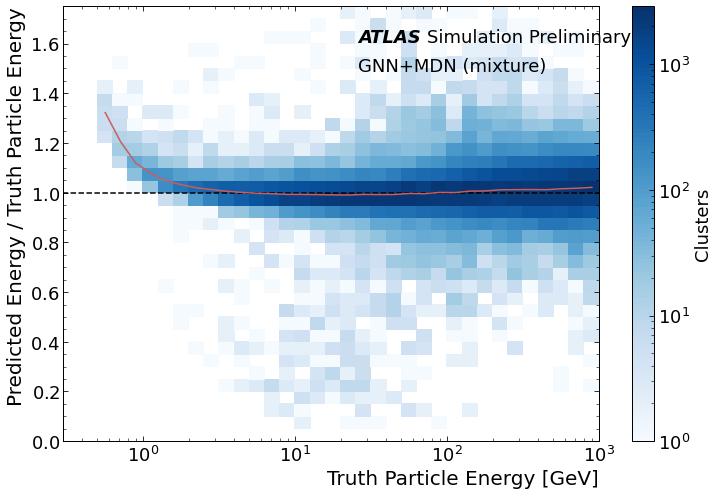

<Figure size 799.992x599.976 with 0 Axes>

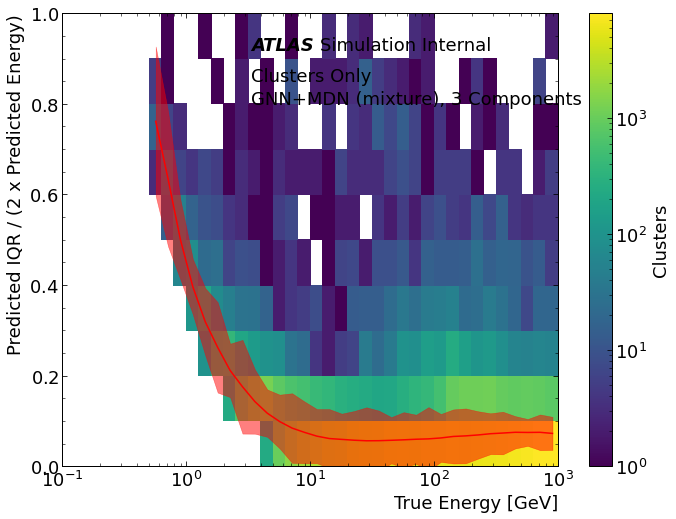

<Figure size 799.992x599.976 with 0 Axes>

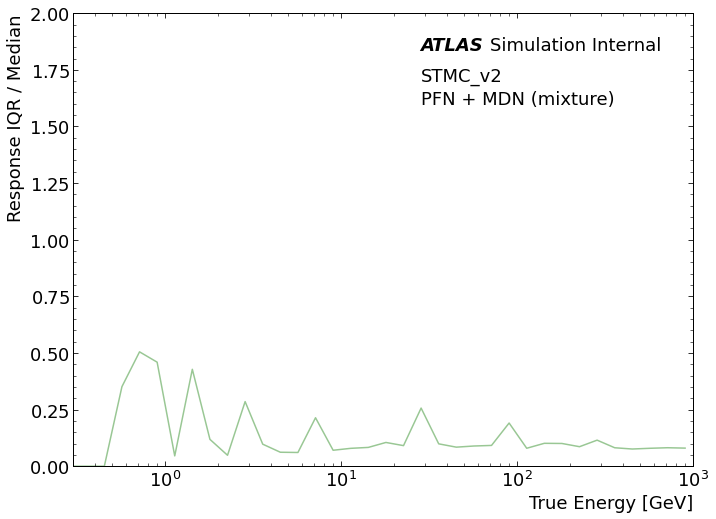

In [207]:
with np.load('/content/drive/MyDrive/ml4pion/model/GNN_MDN_samp2.npz', allow_pickle=True) as data:
#with np.load('/content/drive/MyDrive/ml4pion/model/GNN.npz', allow_pickle=True) as data:
#with np.load('/content/drive/MyDrive/ml4pion/MDN/predictions.npz') as data:
  target = np.log10(np.concatenate(data['targets'])[:,0])
  predict = np.log10(np.concatenate(data['outputs'])[:,:3])
  weight = np.concatenate(data['weight'])
  std = np.concatenate(data['std'])

target = 10**inv_normalize(target)
prediction_, uncertainty_ = eval_cal(weight, predict, std, 'mixture')
prediction = 10**inv_normalize(prediction_)
uncertainty = uncertainty_ * truth_part_e_mean

xcenter, medRegMDN = make_response_plot(target, prediction, 'GNN+MDN (mixture)')

pred_iqr = uncertainty * prediction
iqr_over_median = 2 * pred_iqr / prediction
xcenter, iqrOverMed_MDN_test, learned_error = rum.responsePlot(target, iqr_over_median/2,
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 xlim=(0.1,1000), ylim=(0,1), baseline=False, fill_error=True,
                 step=0.1,
                 xlabel='True Energy [GeV]', ylabel='Predicted IQR / (2 x Predicted Energy)',
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Clusters Only'},
                             {'x': 0.38, 'y': 0.8,  'text': 'GNN+MDN (mixture), 3 Components'}])

xcenter, iqrGNNMDN = rum.resolutionPlot(x=target, y=prediction/target, statistic='std',
                                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'STMC_v2'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN + MDN (mixture)'}])

r2:0.990
PearsonR:0.995, SpearmanR:0.998, MSE:2895.488, MAE:24.755


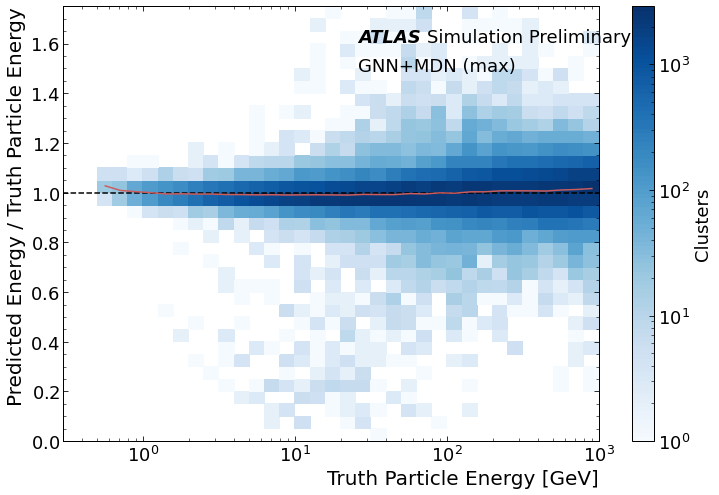

<Figure size 799.992x599.976 with 0 Axes>

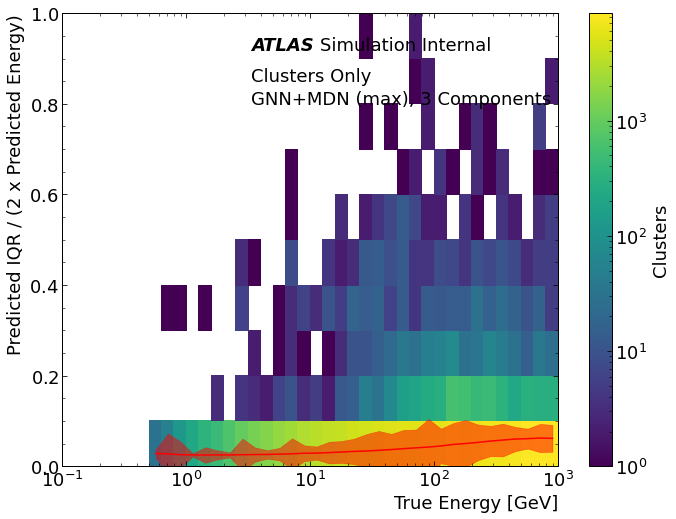

<Figure size 799.992x599.976 with 0 Axes>

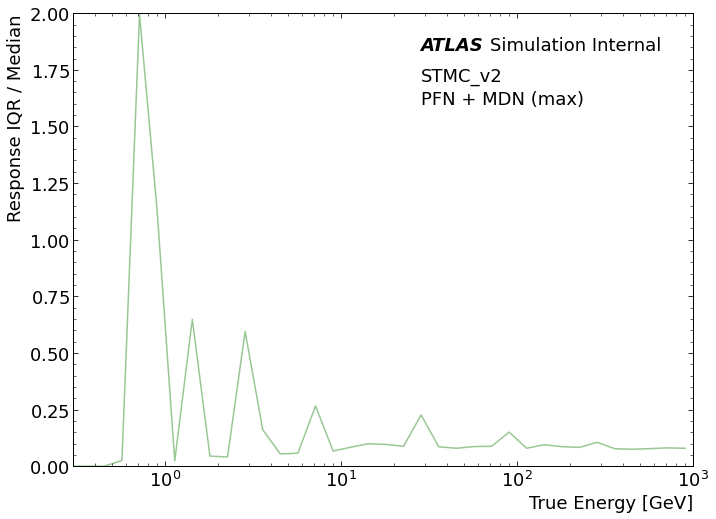

In [209]:
with np.load('/content/drive/MyDrive/ml4pion/model/GNN_MDN_samp2.npz', allow_pickle=True) as data:
#with np.load('/content/drive/MyDrive/ml4pion/model/GNN.npz', allow_pickle=True) as data:
#with np.load('/content/drive/MyDrive/ml4pion/MDN/predictions.npz') as data:
  target = np.log10(np.concatenate(data['targets'])[:,0])
  predict = np.log10(np.concatenate(data['outputs'])[:,:3])
  weight = np.concatenate(data['weight'])
  std = np.concatenate(data['std'])

target = 10**inv_normalize(target)
prediction_, uncertainty_ = eval_cal(weight, predict, std, 'max')
prediction = 10**inv_normalize(prediction_)
uncertainty = uncertainty_ * truth_part_e_mean

xcenter, medRegMDN = make_response_plot(target, prediction, 'GNN+MDN (max)')

pred_iqr = uncertainty * prediction
iqr_over_median = 2 * pred_iqr / prediction
xcenter, iqrOverMed_MDN_test, learned_error = rum.responsePlot(target, iqr_over_median/2,
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 xlim=(0.1,1000), ylim=(0,1), baseline=False, fill_error=True,
                 step=0.1,
                 xlabel='True Energy [GeV]', ylabel='Predicted IQR / (2 x Predicted Energy)',
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Clusters Only'},
                             {'x': 0.38, 'y': 0.8,  'text': 'GNN+MDN (max), 3 Components'}])

xcenter, iqrGNNMDN = rum.resolutionPlot(x=target, y=prediction/target, statistic='std',
                                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'STMC_v2'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN + MDN (max)'}])

r2:0.990
PearsonR:0.995, SpearmanR:0.999, MSE:2736.795, MAE:23.691


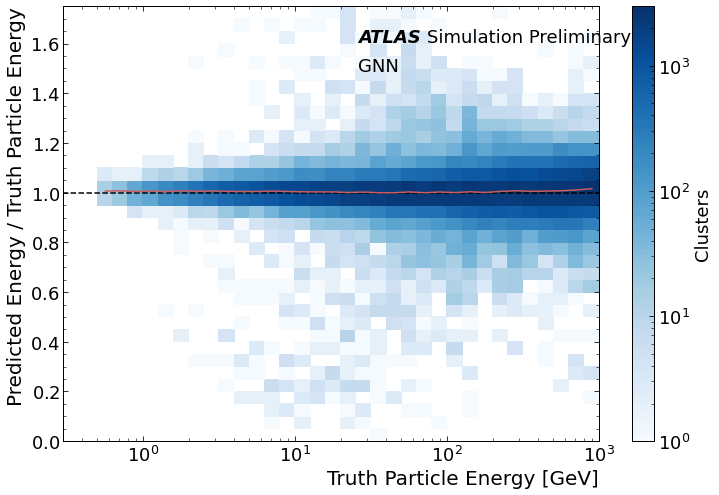

<Figure size 799.992x599.976 with 0 Axes>

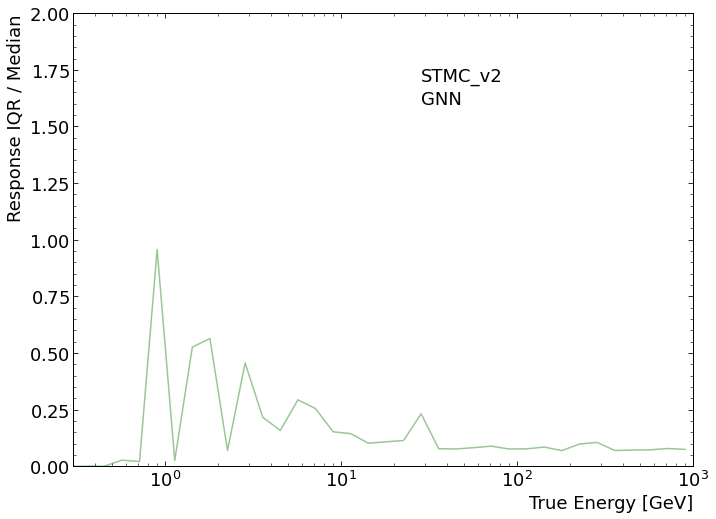

In [204]:
with np.load('/content/drive/MyDrive/ml4pion/model/GNN_samp.npz', allow_pickle=True) as data:
  target_GNN = np.log10(np.concatenate(data['targets'])[:,0])
  predict_GNN = np.log10(np.concatenate(data['outputs'])[:,0])
  target_GNN = 10**inv_normalize(target_GNN)
  prediction_GNN = 10**inv_normalize(predict_GNN)

xcenter, medRegMDN = make_response_plot(target_GNN, prediction_GNN, 'GNN')
xcenter, iqr_curr = rum.resolutionPlot(target_GNN, prediction_GNN/target_GNN,
                                       textlist = [{'x': 0.56, 'y': 0.85, 'text': 'STMC_v2'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'GNN'}])

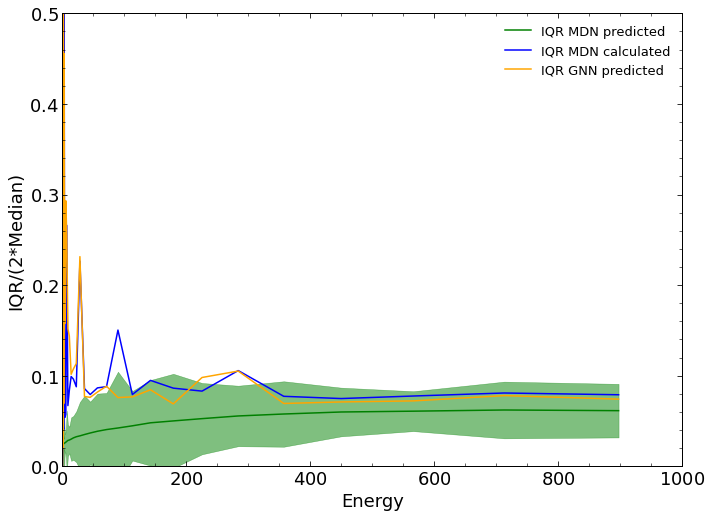

In [210]:
upper = iqrOverMed_MDN_test + learned_error
lower = iqrOverMed_MDN_test - learned_error
plt.plot(xcenter, iqrOverMed_MDN_test, label='IQR MDN predicted', color='green')
plt.fill_between(xcenter, lower, upper, alpha=0.5, color='green')
plt.plot(xcenter, iqrGNNMDN, 'b', label='IQR MDN calculated')
plt.plot(xcenter, iqr_curr, 'orange', label='IQR GNN predicted')
plt.ylabel('IQR/(2*Median)')
plt.xlabel('Energy')
plt.ylim((0,0.5))
plt.xlim((0,1000))
plt.legend()

r2:0.990
PearsonR:0.995, SpearmanR:0.998, MSE:2895.488, MAE:24.755


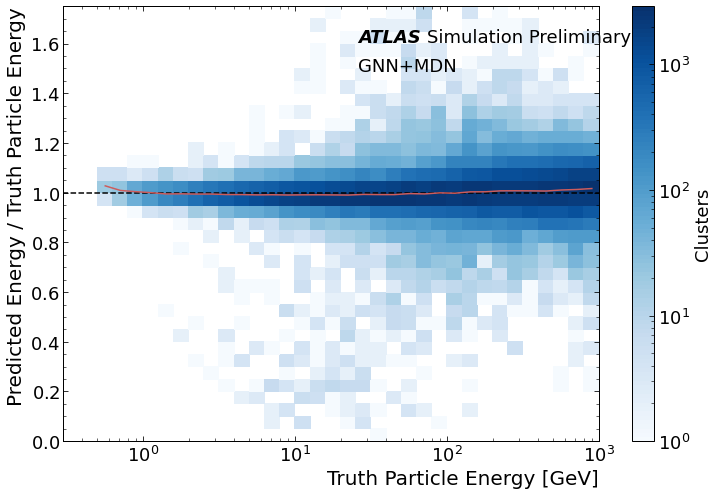

In [185]:
xcenter, medRegMDN = make_response_plot(target, prediction, 'GNN+MDN')

<Figure size 799.992x599.976 with 0 Axes>

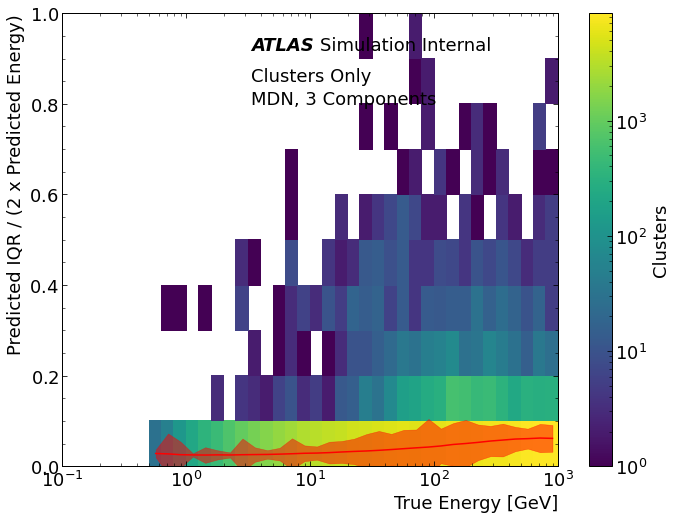

In [189]:
pred_iqr = uncertainty * prediction
iqr_over_median = 2 * pred_iqr / prediction
xcenter, iqrOverMed_MDN_test, learned_error = rum.responsePlot(target, iqr_over_median/2,
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 xlim=(0.1,1000), ylim=(0,1), baseline=False, fill_error=True,
                 step=0.1,
                 xlabel='True Energy [GeV]', ylabel='Predicted IQR / (2 x Predicted Energy)',
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Clusters Only'},
                             {'x': 0.38, 'y': 0.8,  'text': 'MDN, 3 Components'}])

<Figure size 799.992x599.976 with 0 Axes>

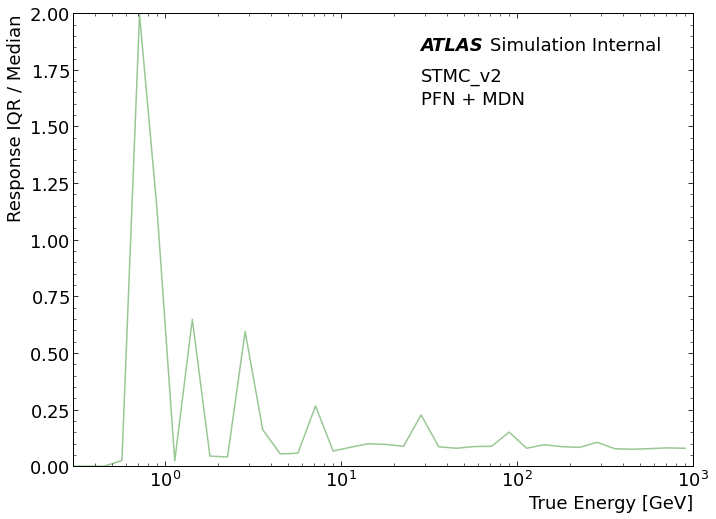

In [190]:
xcenter, iqrGNNMDN = rum.resolutionPlot(x=target, y=prediction/target, statistic='std',
                                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'STMC_v2'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN + MDN'}])

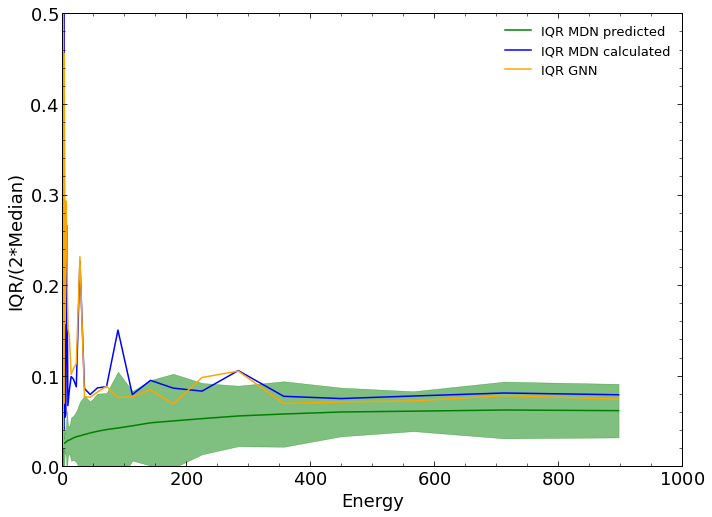

In [191]:
upper = iqrOverMed_MDN_test + learned_error
lower = iqrOverMed_MDN_test - learned_error
plt.plot(xcenter, iqrOverMed_MDN_test, label='IQR MDN predicted', color='green')
plt.fill_between(xcenter, lower, upper, alpha=0.5, color='green')
plt.plot(xcenter, iqrGNNMDN, 'b', label='IQR MDN calculated')
plt.plot(xcenter, iqr_curr, 'orange', label='IQR GNN')
plt.ylabel('IQR/(2*Median)')
plt.xlabel('Energy')
plt.ylim((0,0.5))
plt.xlim((0,1000))
plt.legend()